<a href="https://colab.research.google.com/github/37stu37/FFE/blob/master/FFEpostProcessingRAPIDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Installation
---



In [3]:
!nvidia-smi # allocation must be Tesla T4, P4, or P100

Wed Jul 29 19:12:47 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
#no.of cores each processor is having 
!lscpu | grep 'Core(s) per socket:'
#no.of threads each core is having
!lscpu | grep 'Thread(s) per core'

Core(s) per socket:  2
Thread(s) per core:  2


In [5]:
%%time
%%capture
# Install RAPIDS
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!bash rapidsai-csp-utils/colab/rapids-colab.sh stable

import sys, os

dist_package_index = sys.path.index('/usr/local/lib/python3.6/dist-packages')
sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.6/site-packages'] + sys.path[dist_package_index:]
sys.path
exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals())

CPU times: user 887 ms, sys: 157 ms, total: 1.04 s
Wall time: 8min 24s


In [1]:
%%time
%%capture
!apt update
!apt upgrade
!apt install gdal-bin python-gdal python3-gdal
# Install rtree - Geopandas requirment
!apt install python3-rtree
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes
!pip install memory_profiler
# install parquet libraries
!pip install git+https://github.com/dask/fastparquet
!pip install python-snappy
!pip install pyarrow 

CPU times: user 582 ms, sys: 157 ms, total: 738 ms
Wall time: 5min 11s


In [2]:
from pathlib import Path
import os
from datetime import date

In [3]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import box
import dask.dataframe as dd
pd.options.mode.chained_assignment = None

In [9]:
import cudf
import dask_cudf

#Post-processing process 

1.   Load and concatenate parquet files into dask_cudf
2.   Count 'Source"
1.   Merge with Shapefile (gdf)
1.   Create output data









In [4]:
# Paths
pathShapefile = Path('/content/drive/My Drive/Colab Notebooks/01_Repository/FFE/data/shapefile')
pathParquets = Path('/content/drive/My Drive/Colab Notebooks/02_Output/ffeFinnComparison/output')

print(len(os.listdir(pathParquets)))

['buildings_raw.cpg', 'buildings_raw.dbf', 'buildings_raw.prj', 'buildings_raw.qpj', 'buildings_raw.shp', 'buildings_raw.shx', 'WellWHV_Buildings.prj', 'WellWHV_Buildings.cpg', 'WellWHV_Buildings.shp', 'WellWHV_Buildings.shx', 'WellWHV_Buildings.dbf', 'WellWHV_Buildings.sbn', 'WellWHV_Buildings.sbx', 'WellWHV_Buildings.shp.xml', 'Finn_MeshBlockSummary.prj', 'Finn_MeshBlockSummary.cpg', 'Finn_MeshBlockSummary.qpj', 'Finn_MeshBlockSummary.dbf', 'Finn_MeshBlockSummary.shp', 'Finn_MeshBlockSummary.shx', 'Finn_SA2Summary.shp', 'Finn_SA2Summary.cpg', 'Finn_SA2Summary.dbf', 'Finn_SA2Summary.prj', 'Finn_SA2Summary.qpj', 'Finn_SA2Summary.shx', 'CountBurn-2020-07-29).parquet', 'CountBurn-2020-07-30).parquet', 'Burn3000scenarioWellington.cpg', 'Burn3000scenarioWellington.prj', 'Burn3000scenarioWellington.shp', 'Burn3000scenarioWellington.dbf', 'Burn3000scenarioWellington.shx'] 3001


In [5]:
def read_and_concatenate_parquets(path=pathParquets):
  L = []
  files = pathParquets.glob('*.parquet')
  number = 0
  for file in files:
    number += 1
    print(f"file loaded : {number}/{len(os.listdir(pathParquets))}")
    pqt = pd.read_parquet(file, engine='auto')
    pqt.drop_duplicates(subset ="source", inplace = True)
    L.append(pqt)
  df = dd.concat(L)
  return df

def count_fid_occurences(df):
  count = df['source'].value_counts().compute()
  count_df = pd.DataFrame({'source': count.index, 'count': count.values})
  count_df.to_parquet(str(pathShapefile) + '/' + f'CountBurn-{str(date.today())}.parquet', engine='auto', compression="GZIP")# could be datetime.now
  return count_df

def Merge(countDf,nameShapefile):
  # Shapefile
  gdfShape = gpd.read_file(pathShapefile / nameShapefile)
  gdfShape.insert(0, 'FID', range(0, len(gdfShape)))
  gdfShape.rename(columns={'FID': 'source'}, inplace=True)
  gdfShape = gdfShape[['source', 'geometry']]
  # gdf = pd.DataFrame(gdfShape)
  # cudf_gdf = cudf.DataFrame.from_pandas(gdf)
  # cudf_gdf.rename(columns={'FID': 'source'}, inplace=True)
  # cudf_gdf = cudf_gdf[['source', 'geometry']]
  # countDf as cudf
  # cudf_countDf = cudf.DataFrame.from_pandas(countDf)
  # merge
  merged = countDf.merge(gdfShape, on=['source'], how='left')
  return merged

def createShapefile(df):
  # df = df.to_pandas()
  gdf = gpd.GeoDataFrame(df, geometry='geometry')
  # gdf.plot(column='count', cmap='hsv', legend=True)
  gdf.to_file(os.path.join(str(pathShapefile) + "/" + "Burn3000scenarioWellington.shp"))
  return gdf

In [ ]:
%%time
concatDf = read_and_concatenate_parquets()

In [62]:
concatDf.head()

,source,target,distance,bearing,IgnProbBld,scenario,pid
7388,170,28249,68.394308,322.375819,0.000155,638,499
23611,530,5499,30.503705,229.538987,0.000032,638,499
28592,645,2470,19.815045,64.564272,0.000099,638,499
41678,949,52679,41.119870,73.630562,0.000203,638,499
46422,1061,55683,60.329133,45.623601,0.000322,638,499


In [63]:
%%time
countConcatDf = count_fid_occurences(concatDf)

CPU times: user 26.8 s, sys: 2.33 s, total: 29.1 s
Wall time: 12.7 s


In [ ]:
countConcatDf

In [66]:
%%time
mergedDf = Merge(countConcatDf, 'WellWHV_Buildings.shp')
countShape = createShapefile(mergedDf)

CPU times: user 23.6 s, sys: 3.06 s, total: 26.6 s
Wall time: 44.4 s


In [6]:
%%capture
!pip3 install contextily

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


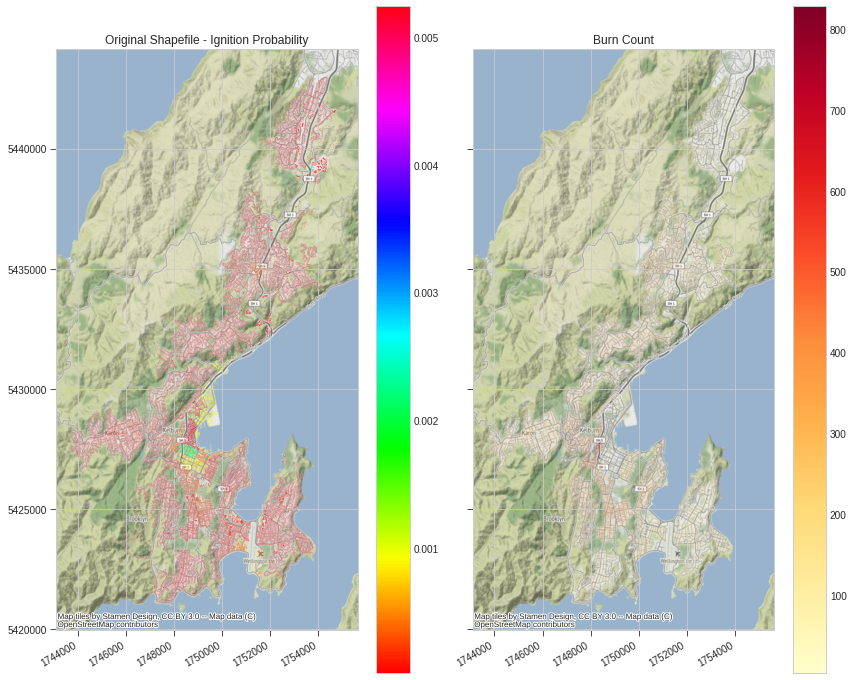

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
%matplotlib inline
plt.style.use('seaborn-whitegrid')

originalShape = gpd.read_file(pathShapefile / 'WellWHV_Buildings.shp')
countShape = gpd.read_file(pathShapefile / 'Burn3000scenarioWellington.shp')

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(12, 10))

p1 = originalShape.plot(ax=ax1, column='IgnProbBld', cmap='hsv', alpha=0.7, legend=True)
ctx.add_basemap(ax1, crs=2193)
p2 = countShape.plot(ax=ax2, column='count', cmap='YlOrRd', alpha=0.7, legend=True)
ctx.add_basemap(ax2, crs=2193)

ax1.set_title('Original Shapefile - Ignition Probability')
ax1.ticklabel_format(useOffset=False, style='plain')
ax2.set_title('Burn Count')
ax2.ticklabel_format(useOffset=False, style='plain')
ax1.tick_params(direction='out', length=6)
ax2.tick_params(direction="out", length=6)

fig.autofmt_xdate()
plt.tight_layout()
plt.show()